### LSTM (Long-short time memory) model for SOC prediction with using LG 18650HG2 Li-ion Battery 

In [21]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
PROCESSED_DATA_DIR = '../../datasets/LG_dataset/LG_HG2_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 128
SEQUENCE_LENGTH = 20  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [5]:
# Custom dataset class for LSTM
class BatteryDatasetLSTM(Dataset):
    def __init__(self, data_tensor, labels_tensor, sequence_length=50, filenames=None, times=None):
        self.sequence_length = sequence_length
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        sequence = self.features[idx:idx_end]
        label = self.labels[idx_end - 1]
        filename = self.filenames[idx_end - 1]
        time = self.times[idx_end - 1]  

        sequence = sequence.clone().detach()
        label = label.clone().detach()

        return sequence, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [6]:
# SoCLSTM Model
class SoCLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SoCLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001, flag=False):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')
        
        if flag:
            model_path = "soc_lstm_model.pth"
            torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)
        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [8]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [9]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [min],Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],Rounded_Time,SourceFile,Power [W]
0,2018-11-26 22:46:24,0.000000,0.000,4.18799,0.0,-0.63095,0.0000,0.000000,0.000000,1.005034,0,585_HPPC_processed.csv,0.0
1,2018-11-26 22:46:25,0.009967,0.598,4.18799,0.0,-0.63095,0.0000,0.000028,0.000000,1.005034,1,585_HPPC_processed.csv,0.0
2,2018-11-26 22:46:26,0.026650,1.599,4.18799,0.0,-0.63095,0.0000,0.000028,0.000000,1.005034,2,585_HPPC_processed.csv,0.0
3,2018-11-26 22:46:27,0.043350,2.601,4.18799,0.0,-0.63095,0.0000,0.000028,0.000000,1.005034,3,585_HPPC_processed.csv,0.0
4,2018-11-26 22:46:28,0.058350,3.501,4.18799,0.0,-0.63095,0.0000,0.000028,0.000000,1.005034,4,585_HPPC_processed.csv,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532257,2018-12-26 22:37:45,27.609450,1656.567,4.06038,0.0,-19.87496,-0.2426,0.000028,-0.243146,0.902752,1657,611_PausCycl_processed.csv,0.0
532258,2018-12-26 22:37:46,27.626117,1657.567,4.06038,0.0,-19.87496,-0.2426,0.000028,-0.243146,0.902752,1658,611_PausCycl_processed.csv,0.0
532259,2018-12-26 22:37:47,27.642800,1658.568,4.06038,0.0,-19.87496,-0.2426,0.000028,-0.243146,0.902752,1659,611_PausCycl_processed.csv,0.0
532260,2018-12-26 22:37:48,27.659433,1659.566,4.06038,0.0,-19.87496,-0.2426,0.000027,-0.243146,0.902752,1660,611_PausCycl_processed.csv,0.0


In [10]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [min],Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],Rounded_Time,SourceFile,Power [W]
0,2018-11-26 22:46:24,0.000000,0.000,1.689285,0.443741,-0.491636,0.0000,0.000000,1.531129,1.005034,0,585_HPPC_processed.csv,0.437382
1,2018-11-26 22:46:25,0.009967,0.598,1.689285,0.443741,-0.491636,0.0000,0.000028,1.531129,1.005034,1,585_HPPC_processed.csv,0.437382
2,2018-11-26 22:46:26,0.026650,1.599,1.689285,0.443741,-0.491636,0.0000,0.000028,1.531129,1.005034,2,585_HPPC_processed.csv,0.437382
3,2018-11-26 22:46:27,0.043350,2.601,1.689285,0.443741,-0.491636,0.0000,0.000028,1.531129,1.005034,3,585_HPPC_processed.csv,0.437382
4,2018-11-26 22:46:28,0.058350,3.501,1.689285,0.443741,-0.491636,0.0000,0.000028,1.531129,1.005034,4,585_HPPC_processed.csv,0.437382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532257,2018-12-26 22:37:45,27.609450,1656.567,1.258734,0.443741,-1.545244,-0.2426,0.000028,1.209896,0.902752,1657,611_PausCycl_processed.csv,0.437382
532258,2018-12-26 22:37:46,27.626117,1657.567,1.258734,0.443741,-1.545244,-0.2426,0.000028,1.209896,0.902752,1658,611_PausCycl_processed.csv,0.437382
532259,2018-12-26 22:37:47,27.642800,1658.568,1.258734,0.443741,-1.545244,-0.2426,0.000028,1.209896,0.902752,1659,611_PausCycl_processed.csv,0.437382
532260,2018-12-26 22:37:48,27.659433,1659.566,1.258734,0.443741,-1.545244,-0.2426,0.000027,1.209896,0.902752,1660,611_PausCycl_processed.csv,0.437382


In [11]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [12]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [13]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [14]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetLSTM(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetLSTM(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetLSTM(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [15]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'571_Mixed7_processed.csv', '551_Mixed2_processed.csv', '589_HWFET_processed.csv', '557_Mixed3_processed.csv', '610_Cap_1C_processed.csv', '590_Mixed6_processed.csv', '604_Mixed3_processed.csv', '601_US06_processed.csv', '562_Mixed8_processed.csv', '611_Mixed6_processed.csv', '576_UDDS_processed.csv', '590_PausCycl_processed.csv', '575_HPPC_processed.csv', '556_HWFET_processed.csv', '596_Cap_1C_processed.csv', '604_Mixed8_processed.csv', '611_Mixed5_processed.csv', '552_Mixed5_processed.csv', '551_LA92_processed.csv', '610_Mixed2_processed.csv', '601_Mixed1_processed.csv', '552_Mixed3_processed.csv', '562_Mixed5_processed.csv', '601_Mixed2_processed.csv', '596_UDDS_processed.csv', '611_Cap_1C_processed.csv', '556_US06_processed.csv', '590_Mixed7_processed.csv', '611_Mixed7_processed.csv', '602_Mixed4_processed.csv', '571_PausCycl_processed.csv', '552_Mixed4_processed.csv', '571_Mixed4_processed.csv', '610_Mixed1_processed.csv', '590_Mixed8_processed.csv', '556_Mixed2_p

In [17]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([404215, 5])
Test features shape: torch.Size([53848, 5])
Train labels shape: torch.Size([404215])
Test labels shape: torch.Size([53848])


## Hyperparameter tuning

In [18]:
# Define Optuna objective function
EPOCHS = 10
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 16, 128)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    # Instantiate model with suggested hyperparameters
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).type(torch.float32).to(device)

    # Define your loss function and optimizer with suggested hyperparameters
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Call your train and validate function
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Extract last validation loss
    last_val_loss = history['val_loss'][-1]
    return last_val_loss


In [ ]:
# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Extract best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial}")

best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

[I 2025-07-31 14:37:56,607] A new study created in memory with name: no-name-c5d003f0-65ec-4d31-beb9-a63251c0e6ca
Epoch: 0/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.35it/s]


Epoch 1/10, Train Loss: 0.05869616228970846, Validation Loss: 0.0016234839162891524
Time taken for epoch: 51.48207521 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:50<00:00, 61.98it/s]


Epoch 2/10, Train Loss: 0.0010858685327467662, Validation Loss: 0.0006344279579814362
Time taken for epoch: 50.95431447 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:51<00:00, 60.79it/s]


Epoch 3/10, Train Loss: 0.000706997661311488, Validation Loss: 0.0003867543142208347
Time taken for epoch: 51.94973564 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:52<00:00, 59.68it/s]


Epoch 4/10, Train Loss: 0.0004757822160741591, Validation Loss: 0.00027260806767408306
Time taken for epoch: 52.91809511 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.35it/s]


Epoch 5/10, Train Loss: 0.0003626041380000664, Validation Loss: 0.00022390568160755863
Time taken for epoch: 51.47634315 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.63it/s]


Epoch 6/10, Train Loss: 0.00028205464504872305, Validation Loss: 0.00018653772718658454
Time taken for epoch: 51.24669671 seconds


Epoch: 6/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.24it/s]


Epoch 7/10, Train Loss: 0.00022074418844058666, Validation Loss: 0.0001693407622703482
Time taken for epoch: 51.56915522 seconds


Epoch: 7/10: 100%|██████████| 3158/3158 [00:52<00:00, 59.85it/s]


Epoch 8/10, Train Loss: 0.00017371789259878323, Validation Loss: 0.00015543946782718669
Time taken for epoch: 52.77159119 seconds


Epoch: 8/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.89it/s]


Epoch 9/10, Train Loss: 0.00013725948965276997, Validation Loss: 0.00013932497372689802
Time taken for epoch: 51.03294182 seconds


Epoch: 9/10: 100%|██████████| 3158/3158 [00:55<00:00, 57.17it/s]
[I 2025-07-31 14:48:00,602] Trial 0 finished with value: 0.00012035071847377732 and parameters: {'hidden_size': 40, 'num_layers': 5, 'learning_rate': 1.758091942592937e-05}. Best is trial 0 with value: 0.00012035071847377732.


Epoch 10/10, Train Loss: 0.00010879845061523654, Validation Loss: 0.00012035071847377732
Time taken for epoch: 55.24377465 seconds


Epoch: 0/10: 100%|██████████| 3158/3158 [01:05<00:00, 48.27it/s]


Epoch 1/10, Train Loss: 0.0005581296564824589, Validation Loss: 0.0001409679076086322
Time taken for epoch: 65.42258120 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [01:05<00:00, 48.29it/s]


Epoch 2/10, Train Loss: 3.856304804920356e-05, Validation Loss: 3.824964993962757e-05
Time taken for epoch: 65.39959002 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [01:05<00:00, 47.87it/s]


Epoch 3/10, Train Loss: 2.781185776429987e-05, Validation Loss: 4.904268387336244e-05
Time taken for epoch: 65.97510386 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [01:05<00:00, 47.88it/s]


Epoch 4/10, Train Loss: 2.1196763816842944e-05, Validation Loss: 5.2473791041967184e-05
Time taken for epoch: 65.96318579 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [01:05<00:00, 48.36it/s]


Epoch 5/10, Train Loss: 1.9550150597375656e-05, Validation Loss: 5.709477276192769e-05
Time taken for epoch: 65.29947138 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [01:03<00:00, 49.88it/s]


Epoch 6/10, Train Loss: 1.6268822516174115e-05, Validation Loss: 7.4266125607177e-05
Time taken for epoch: 63.31825185 seconds


Epoch: 6/10: 100%|██████████| 3158/3158 [01:03<00:00, 49.87it/s]


Epoch 7/10, Train Loss: 1.4650925017003408e-05, Validation Loss: 9.150423403567141e-05
Time taken for epoch: 63.32771754 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3158/3158 [01:05<00:00, 48.41it/s]


Epoch 8/10, Train Loss: 1.3791762466763286e-05, Validation Loss: 8.036495975839326e-05
Time taken for epoch: 65.24288225 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3158/3158 [01:06<00:00, 47.22it/s]


Epoch 9/10, Train Loss: 1.222023104500058e-05, Validation Loss: 7.744923586466796e-05
Time taken for epoch: 66.87918329 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3158/3158 [01:07<00:00, 46.73it/s]
[I 2025-07-31 15:00:30,978] Trial 1 finished with value: 5.685595746340636e-05 and parameters: {'hidden_size': 101, 'num_layers': 5, 'learning_rate': 0.005193556823056898}. Best is trial 1 with value: 5.685595746340636e-05.


Epoch 10/10, Train Loss: 1.397505981570123e-05, Validation Loss: 5.685595746340636e-05
Time taken for epoch: 67.57903337 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.95it/s]


Epoch 1/10, Train Loss: 0.0006371181766799728, Validation Loss: 3.989984038544547e-05
Time taken for epoch: 55.44935489 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:56<00:00, 56.18it/s]


Epoch 2/10, Train Loss: 2.334757419617414e-05, Validation Loss: 5.394328179771349e-05
Time taken for epoch: 56.21049356 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.91it/s]


Epoch 3/10, Train Loss: 1.952452241056965e-05, Validation Loss: 4.920092042089334e-05
Time taken for epoch: 55.49349976 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:56<00:00, 55.48it/s]


Epoch 4/10, Train Loss: 1.6433772267488883e-05, Validation Loss: 5.439532675460402e-05
Time taken for epoch: 56.92112088 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.56it/s]


Epoch 5/10, Train Loss: 1.4366404677855595e-05, Validation Loss: 4.7110566087357086e-05
Time taken for epoch: 55.83513975 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:56<00:00, 55.78it/s]


Epoch 6/10, Train Loss: 1.3208943779647254e-05, Validation Loss: 5.2421152669821045e-05
Time taken for epoch: 56.61866808 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3158/3158 [00:56<00:00, 55.61it/s]


Epoch 7/10, Train Loss: 1.2484581980006475e-05, Validation Loss: 6.086136576495949e-05
Time taken for epoch: 56.79158545 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3158/3158 [00:55<00:00, 57.26it/s]


Epoch 8/10, Train Loss: 1.1436445461727374e-05, Validation Loss: 5.343744788530265e-05
Time taken for epoch: 55.15430212 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3158/3158 [00:56<00:00, 56.02it/s]


Epoch 9/10, Train Loss: 1.078917318007323e-05, Validation Loss: 4.219519973087939e-05
Time taken for epoch: 56.37124991 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3158/3158 [00:54<00:00, 57.62it/s]
[I 2025-07-31 15:11:16,046] Trial 2 finished with value: 6.715817374609425e-05 and parameters: {'hidden_size': 83, 'num_layers': 4, 'learning_rate': 0.0016357564027850875}. Best is trial 1 with value: 5.685595746340636e-05.


Epoch 10/10, Train Loss: 1.0563328503606264e-05, Validation Loss: 6.715817374609425e-05
Time taken for epoch: 54.80733275 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3158/3158 [00:53<00:00, 58.73it/s]


Epoch 1/10, Train Loss: 0.0008055169023567938, Validation Loss: 6.465681378633229e-05
Time taken for epoch: 53.77469611 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:52<00:00, 59.84it/s]


Epoch 2/10, Train Loss: 1.9797602822169664e-05, Validation Loss: 0.00011631981204135253
Time taken for epoch: 52.77387595 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:52<00:00, 59.82it/s]


Epoch 3/10, Train Loss: 1.8000318420978526e-05, Validation Loss: 6.827615767669015e-05
Time taken for epoch: 52.78916693 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:55<00:00, 57.38it/s]


Epoch 4/10, Train Loss: 1.5817270515803955e-05, Validation Loss: 3.899500641483141e-05
Time taken for epoch: 55.03744292 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:54<00:00, 57.85it/s]


Epoch 5/10, Train Loss: 1.3650141828743123e-05, Validation Loss: 5.498183250364411e-05
Time taken for epoch: 54.59405398 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:52<00:00, 59.90it/s]


Epoch 6/10, Train Loss: 1.2808513224324553e-05, Validation Loss: 4.464060071749998e-05
Time taken for epoch: 52.72308278 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3158/3158 [00:51<00:00, 60.75it/s]


Epoch 7/10, Train Loss: 1.2135338242182896e-05, Validation Loss: 4.4503844418793844e-05
Time taken for epoch: 51.98229766 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.49it/s]


Epoch 8/10, Train Loss: 1.1258506387433064e-05, Validation Loss: 5.83912577213942e-05
Time taken for epoch: 52.20737791 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.53it/s]


Epoch 9/10, Train Loss: 1.1316549659411163e-05, Validation Loss: 4.2233661769298316e-05
Time taken for epoch: 52.17145610 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3158/3158 [00:51<00:00, 60.82it/s]
[I 2025-07-31 15:21:24,508] Trial 3 finished with value: 4.928670486502393e-05 and parameters: {'hidden_size': 63, 'num_layers': 3, 'learning_rate': 0.0015430906914921348}. Best is trial 3 with value: 4.928670486502393e-05.


Epoch 10/10, Train Loss: 1.0614258198198084e-05, Validation Loss: 4.928670486502393e-05
Time taken for epoch: 51.92573786 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3158/3158 [00:56<00:00, 56.36it/s]


Epoch 1/10, Train Loss: 0.0013216935144624584, Validation Loss: 5.033491820943852e-05
Time taken for epoch: 56.03166127 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:56<00:00, 55.42it/s]


Epoch 2/10, Train Loss: 1.8754704874213993e-05, Validation Loss: 7.013294326206592e-05
Time taken for epoch: 56.98484206 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:58<00:00, 54.44it/s]


Epoch 3/10, Train Loss: 1.5208969693972752e-05, Validation Loss: 4.762306355582353e-05
Time taken for epoch: 58.00833583 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:56<00:00, 55.58it/s]


Epoch 4/10, Train Loss: 1.3586734861944806e-05, Validation Loss: 4.731804660669094e-05
Time taken for epoch: 56.82316971 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:57<00:00, 55.37it/s]


Epoch 5/10, Train Loss: 1.2729650794735294e-05, Validation Loss: 4.549489432950695e-05
Time taken for epoch: 57.03401303 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:58<00:00, 53.96it/s]


Epoch 6/10, Train Loss: 1.1883381182564106e-05, Validation Loss: 4.272141490180216e-05
Time taken for epoch: 58.52184939 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3158/3158 [00:56<00:00, 56.12it/s]


Epoch 7/10, Train Loss: 1.1498843149684064e-05, Validation Loss: 5.72880106798185e-05
Time taken for epoch: 56.27942204 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3158/3158 [00:56<00:00, 55.47it/s]


Epoch 8/10, Train Loss: 1.0970390202007416e-05, Validation Loss: 5.046122521951862e-05
Time taken for epoch: 56.93460035 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3158/3158 [00:56<00:00, 55.76it/s]


Epoch 9/10, Train Loss: 1.0744057008518807e-05, Validation Loss: 4.4736027609293026e-05
Time taken for epoch: 56.63617897 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.49it/s]
[I 2025-07-31 15:32:23,843] Trial 4 finished with value: 3.620212527322295e-05 and parameters: {'hidden_size': 105, 'num_layers': 3, 'learning_rate': 0.00043744795844566733}. Best is trial 4 with value: 3.620212527322295e-05.


Epoch 10/10, Train Loss: 1.0327542070858931e-05, Validation Loss: 3.620212527322295e-05
Time taken for epoch: 55.90460753 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3158/3158 [00:49<00:00, 63.24it/s]


Epoch 1/10, Train Loss: 0.0011773557003587766, Validation Loss: 5.068898601529611e-05
Time taken for epoch: 49.94262314 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.79it/s]


Epoch 2/10, Train Loss: 2.185786379811348e-05, Validation Loss: 3.936983740498656e-05
Time taken for epoch: 51.10872221 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:50<00:00, 62.08it/s]


Epoch 3/10, Train Loss: 1.810804648081976e-05, Validation Loss: 4.78029850361525e-05
Time taken for epoch: 50.87264681 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:50<00:00, 62.03it/s]


Epoch 4/10, Train Loss: 1.5180376556454944e-05, Validation Loss: 4.133164864393608e-05
Time taken for epoch: 50.91025877 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:50<00:00, 62.21it/s]


Epoch 5/10, Train Loss: 1.4032504779556137e-05, Validation Loss: 4.6511556028199384e-05
Time taken for epoch: 50.76426864 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:50<00:00, 62.30it/s]


Epoch 6/10, Train Loss: 1.3333260155041697e-05, Validation Loss: 6.756322534535042e-05
Time taken for epoch: 50.68885303 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3158/3158 [00:50<00:00, 62.53it/s]


Epoch 7/10, Train Loss: 1.2005214373617408e-05, Validation Loss: 5.279594826125201e-05
Time taken for epoch: 50.50233221 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3158/3158 [00:49<00:00, 63.98it/s]


Epoch 8/10, Train Loss: 1.1309022398230184e-05, Validation Loss: 3.827818941551356e-05
Time taken for epoch: 49.36531973 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3158/3158 [00:50<00:00, 62.19it/s]


Epoch 9/10, Train Loss: 1.1078912668391028e-05, Validation Loss: 4.090049780552902e-05
Time taken for epoch: 50.77975130 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3158/3158 [00:50<00:00, 62.48it/s]
[I 2025-07-31 15:42:12,348] Trial 5 finished with value: 5.273121217987723e-05 and parameters: {'hidden_size': 64, 'num_layers': 4, 'learning_rate': 0.0010021567025071643}. Best is trial 4 with value: 3.620212527322295e-05.


Epoch 10/10, Train Loss: 1.0282506404849458e-05, Validation Loss: 5.273121217987723e-05
Time taken for epoch: 50.54761744 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.51it/s]


Epoch 1/10, Train Loss: 0.0043780707082152455, Validation Loss: 0.00026319347378524427
Time taken for epoch: 52.19430995 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:51<00:00, 60.75it/s]


Epoch 2/10, Train Loss: 0.0001558958383571433, Validation Loss: 0.0001160228254975507
Time taken for epoch: 51.98660994 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.37it/s]


Epoch 3/10, Train Loss: 2.9244475531583545e-05, Validation Loss: 6.826129973740742e-05
Time taken for epoch: 52.31095076 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.12it/s]


Epoch 4/10, Train Loss: 1.4882669204868668e-05, Validation Loss: 6.50888466024017e-05
Time taken for epoch: 52.52812362 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.62it/s]


Epoch 5/10, Train Loss: 1.3052855233555874e-05, Validation Loss: 7.093638264391616e-05
Time taken for epoch: 52.09309387 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.64it/s]


Epoch 6/10, Train Loss: 1.2148507625673587e-05, Validation Loss: 4.9001827508744525e-05
Time taken for epoch: 52.08051944 seconds


Epoch: 6/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.26it/s]


Epoch 7/10, Train Loss: 1.1355483297300774e-05, Validation Loss: 4.9808668625017266e-05
Time taken for epoch: 52.40804982 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.46it/s]


Epoch 8/10, Train Loss: 1.1042124802964093e-05, Validation Loss: 5.036638897524489e-05
Time taken for epoch: 52.23280692 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.56it/s]


Epoch 9/10, Train Loss: 1.061264397002116e-05, Validation Loss: 4.516230993163067e-05
Time taken for epoch: 52.14882064 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.37it/s]
[I 2025-07-31 15:52:13,725] Trial 6 finished with value: 4.804195071046304e-05 and parameters: {'hidden_size': 62, 'num_layers': 5, 'learning_rate': 0.00012759343625403632}. Best is trial 4 with value: 3.620212527322295e-05.


Epoch 10/10, Train Loss: 1.0319627078161928e-05, Validation Loss: 4.804195071046304e-05
Time taken for epoch: 52.31671882 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.35it/s]


Epoch 1/10, Train Loss: 0.0018179012081402637, Validation Loss: 5.8626563705811085e-05
Time taken for epoch: 52.32608390 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.52it/s]


Epoch 2/10, Train Loss: 3.5369914374537735e-05, Validation Loss: 5.539347942552853e-05
Time taken for epoch: 51.33558083 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.68it/s]


Epoch 3/10, Train Loss: 3.209845370375264e-05, Validation Loss: 4.262272313519331e-05
Time taken for epoch: 51.20219350 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.59it/s]


Epoch 4/10, Train Loss: 2.3500888481964194e-05, Validation Loss: 5.175842851553247e-05
Time taken for epoch: 51.27469802 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.36it/s]


Epoch 5/10, Train Loss: 1.8683674754519047e-05, Validation Loss: 6.32963365464777e-05
Time taken for epoch: 52.32085657 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.36it/s]


Epoch 6/10, Train Loss: 1.6410339069106394e-05, Validation Loss: 5.8971807796481814e-05
Time taken for epoch: 52.32596517 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3158/3158 [00:52<00:00, 60.56it/s]


Epoch 7/10, Train Loss: 1.696015447227179e-05, Validation Loss: 0.0001233919646297392
Time taken for epoch: 52.14913249 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.43it/s]


Epoch 8/10, Train Loss: 1.3837219167548306e-05, Validation Loss: 8.973943971698445e-05
Time taken for epoch: 51.41379857 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3158/3158 [00:51<00:00, 60.86it/s]


Epoch 9/10, Train Loss: 1.2356211116759122e-05, Validation Loss: 3.8954042993296904e-05
Time taken for epoch: 51.89019942 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3158/3158 [00:51<00:00, 61.60it/s]
[I 2025-07-31 16:02:06,254] Trial 7 finished with value: 3.903444745169548e-05 and parameters: {'hidden_size': 71, 'num_layers': 2, 'learning_rate': 0.019904374669532397}. Best is trial 4 with value: 3.620212527322295e-05.


Epoch 10/10, Train Loss: 1.2676299426861473e-05, Validation Loss: 3.903444745169548e-05
Time taken for epoch: 51.26597786 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3158/3158 [00:54<00:00, 57.53it/s]


Epoch 1/10, Train Loss: 0.0012601365108333615, Validation Loss: 4.884590010686686e-05
Time taken for epoch: 54.90030289 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.46it/s]


Epoch 2/10, Train Loss: 3.9320516585297335e-05, Validation Loss: 0.00013301168312925942
Time taken for epoch: 55.93837166 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:56<00:00, 56.13it/s]


Epoch 3/10, Train Loss: 3.612653230931163e-05, Validation Loss: 0.00015396928542386822
Time taken for epoch: 56.26381993 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.96it/s]


Epoch 4/10, Train Loss: 2.8112438880970186e-05, Validation Loss: 8.084440278639067e-05
Time taken for epoch: 55.44529724 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:56<00:00, 56.31it/s]


Epoch 5/10, Train Loss: 2.4038694408196583e-05, Validation Loss: 0.00010169850664153473
Time taken for epoch: 56.08003402 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.59it/s]


Epoch 6/10, Train Loss: 1.9406934427659425e-05, Validation Loss: 8.377238150664578e-05
Time taken for epoch: 55.80833602 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.70it/s]


Epoch 7/10, Train Loss: 1.688816412935369e-05, Validation Loss: 5.348270797739061e-05
Time taken for epoch: 55.70032024 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3158/3158 [00:56<00:00, 55.98it/s]


Epoch 8/10, Train Loss: 1.631746583605271e-05, Validation Loss: 7.533615286989509e-05
Time taken for epoch: 56.41002560 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3158/3158 [00:56<00:00, 56.20it/s]


Epoch 9/10, Train Loss: 1.44210741073822e-05, Validation Loss: 5.701382581379169e-05
Time taken for epoch: 56.19603705 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3158/3158 [00:55<00:00, 56.47it/s]
[I 2025-07-31 16:12:49,447] Trial 8 finished with value: 7.120989973678684e-05 and parameters: {'hidden_size': 72, 'num_layers': 5, 'learning_rate': 0.00837781748543315}. Best is trial 4 with value: 3.620212527322295e-05.


Epoch 10/10, Train Loss: 1.3686299177824147e-05, Validation Loss: 7.120989973678684e-05
Time taken for epoch: 55.92632627 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3158/3158 [00:48<00:00, 65.19it/s]


Epoch 1/10, Train Loss: 0.037806506818478, Validation Loss: 0.0009181964727270582
Time taken for epoch: 48.44635153 seconds


Epoch: 1/10: 100%|██████████| 3158/3158 [00:47<00:00, 66.29it/s]


Epoch 2/10, Train Loss: 0.0007509603292223504, Validation Loss: 0.0004680174935877066
Time taken for epoch: 47.63886094 seconds


Epoch: 2/10: 100%|██████████| 3158/3158 [00:48<00:00, 65.57it/s]


Epoch 3/10, Train Loss: 0.000479440900087427, Validation Loss: 0.00026569720787593024
Time taken for epoch: 48.16330409 seconds


Epoch: 3/10: 100%|██████████| 3158/3158 [00:47<00:00, 66.89it/s]


Epoch 4/10, Train Loss: 0.0002977693301683177, Validation Loss: 0.0001734815732358529
Time taken for epoch: 47.21191835 seconds


Epoch: 4/10: 100%|██████████| 3158/3158 [00:47<00:00, 66.81it/s]


Epoch 5/10, Train Loss: 0.00019448901864563365, Validation Loss: 0.00014019510374598196
Time taken for epoch: 47.26860762 seconds


Epoch: 5/10: 100%|██████████| 3158/3158 [00:48<00:00, 64.67it/s]


Epoch 6/10, Train Loss: 0.00012914931699807133, Validation Loss: 0.00011114823015109511
Time taken for epoch: 48.83494473 seconds


Epoch: 6/10: 100%|██████████| 3158/3158 [00:48<00:00, 65.20it/s]


Epoch 7/10, Train Loss: 8.215252882685199e-05, Validation Loss: 8.827628908089157e-05
Time taken for epoch: 48.44221926 seconds


Epoch: 7/10: 100%|██████████| 3158/3158 [00:47<00:00, 65.87it/s]


Epoch 8/10, Train Loss: 5.125689774793568e-05, Validation Loss: 6.957002833533564e-05
Time taken for epoch: 47.94436717 seconds


Epoch: 8/10: 100%|██████████| 3158/3158 [00:47<00:00, 66.16it/s]


Epoch 9/10, Train Loss: 3.299192100981379e-05, Validation Loss: 6.662204536277379e-05
Time taken for epoch: 47.73647928 seconds


Epoch: 9/10: 100%|██████████| 3158/3158 [00:48<00:00, 65.21it/s]
[I 2025-07-31 16:21:58,873] Trial 9 finished with value: 6.003767383201217e-05 and parameters: {'hidden_size': 24, 'num_layers': 4, 'learning_rate': 3.583461641953618e-05}. Best is trial 4 with value: 3.620212527322295e-05.


Epoch 10/10, Train Loss: 2.2439643630170258e-05, Validation Loss: 6.003767383201217e-05
Time taken for epoch: 48.42677379 seconds
Early stopping triggered
Best trial: FrozenTrial(number=4, state=TrialState.COMPLETE, values=[3.620212527322295e-05], datetime_start=datetime.datetime(2025, 7, 31, 15, 21, 24, 509927), datetime_complete=datetime.datetime(2025, 7, 31, 15, 32, 23, 843578), params={'hidden_size': 105, 'num_layers': 3, 'learning_rate': 0.00043744795844566733}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=128, log=False, low=16, step=1), 'num_layers': IntDistribution(high=5, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, trial_id=4, value=None)
Best hyperparameters: {'hidden_size': 105, 'num_layers': 3, 'learning_rate': 0.00043744795844566733}


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [24]:
# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

## Best hyperparameters: {'hidden_size': 105, 'num_layers': 3, 'learning_rate': 0.00043744795844566733}

In [25]:
# Initialize the model, loss function, and optimizer
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']
lr = best_hyperparams['learning_rate']

EPOCHS = 20

model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers)
model.to(device).type(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCLSTM(
  (lstm): LSTM(5, 105, num_layers=3, batch_first=True)
  (fc): Linear(in_features=105, out_features=1, bias=True)
)
Trainable parameters: 225226


Epoch: 0/20: 100%|██████████| 3158/3158 [00:56<00:00, 55.54it/s]


Epoch 1/20, Train Loss: 0.0021532778606210717, Validation Loss: 0.00010243697282954719
Time taken for epoch: 56.86326623 seconds


Epoch: 1/20: 100%|██████████| 3158/3158 [00:56<00:00, 55.45it/s]


Epoch 2/20, Train Loss: 2.0582527794442314e-05, Validation Loss: 4.318657842607757e-05
Time taken for epoch: 56.95501518 seconds


Epoch: 2/20: 100%|██████████| 3158/3158 [00:57<00:00, 55.37it/s]


Epoch 3/20, Train Loss: 1.6216693413708453e-05, Validation Loss: 4.149215212196834e-05
Time taken for epoch: 57.03364182 seconds


Epoch: 3/20: 100%|██████████| 3158/3158 [00:57<00:00, 55.03it/s]


Epoch 4/20, Train Loss: 1.420450021323931e-05, Validation Loss: 5.0803344513927e-05
Time taken for epoch: 57.38859344 seconds


Epoch: 4/20: 100%|██████████| 3158/3158 [00:57<00:00, 55.07it/s]


Epoch 5/20, Train Loss: 1.2948570270962106e-05, Validation Loss: 4.580548468237346e-05
Time taken for epoch: 57.34544325 seconds


Epoch: 5/20: 100%|██████████| 3158/3158 [00:56<00:00, 55.79it/s]


Epoch 6/20, Train Loss: 1.2136933481057957e-05, Validation Loss: 4.205636290639678e-05
Time taken for epoch: 56.60525203 seconds
Early stopping triggered


Epoch: 6/20: 100%|██████████| 3158/3158 [00:56<00:00, 55.79it/s]


Epoch 7/20, Train Loss: 1.1473694575894728e-05, Validation Loss: 4.248413338326431e-05
Time taken for epoch: 56.61094403 seconds
Early stopping triggered


Epoch: 7/20: 100%|██████████| 3158/3158 [00:59<00:00, 53.24it/s]


Epoch 8/20, Train Loss: 1.1310988598696715e-05, Validation Loss: 5.515092327839931e-05
Time taken for epoch: 59.32408428 seconds
Early stopping triggered


Epoch: 8/20: 100%|██████████| 3158/3158 [00:56<00:00, 55.95it/s]


Epoch 9/20, Train Loss: 1.0745775759971136e-05, Validation Loss: 3.901975327420996e-05
Time taken for epoch: 56.44778085 seconds
Early stopping triggered


Epoch: 9/20: 100%|██████████| 3158/3158 [00:59<00:00, 53.42it/s]


Epoch 10/20, Train Loss: 1.0327473933923528e-05, Validation Loss: 5.796728545487597e-05
Time taken for epoch: 59.12289238 seconds
Early stopping triggered


Epoch: 10/20: 100%|██████████| 3158/3158 [00:57<00:00, 55.07it/s]


Epoch 11/20, Train Loss: 1.0028768417374001e-05, Validation Loss: 5.057293437351924e-05
Time taken for epoch: 57.34423375 seconds
Early stopping triggered


Epoch: 11/20: 100%|██████████| 3158/3158 [00:59<00:00, 53.52it/s]


Epoch 12/20, Train Loss: 9.893698449791001e-06, Validation Loss: 4.377244645465731e-05
Time taken for epoch: 59.00558901 seconds
Early stopping triggered


Epoch: 12/20: 100%|██████████| 3158/3158 [00:58<00:00, 53.75it/s]


Epoch 13/20, Train Loss: 9.644272872843578e-06, Validation Loss: 4.600222730080018e-05
Time taken for epoch: 58.75276995 seconds
Early stopping triggered


Epoch: 13/20: 100%|██████████| 3158/3158 [00:57<00:00, 54.76it/s]


Epoch 14/20, Train Loss: 9.433061957560225e-06, Validation Loss: 4.622544274218595e-05
Time taken for epoch: 57.66858649 seconds
Early stopping triggered


Epoch: 14/20: 100%|██████████| 3158/3158 [00:56<00:00, 55.87it/s]


Epoch 15/20, Train Loss: 9.2574348894291e-06, Validation Loss: 4.5746804689734536e-05
Time taken for epoch: 56.52732038 seconds
Early stopping triggered


Epoch: 15/20: 100%|██████████| 3158/3158 [00:58<00:00, 54.27it/s]


Epoch 16/20, Train Loss: 8.799582621837778e-06, Validation Loss: 6.136510967411711e-05
Time taken for epoch: 58.19190955 seconds
Early stopping triggered


Epoch: 16/20: 100%|██████████| 3158/3158 [00:58<00:00, 53.99it/s]


Epoch 17/20, Train Loss: 8.675479857747476e-06, Validation Loss: 4.037354145538442e-05
Time taken for epoch: 58.49704313 seconds
Early stopping triggered


Epoch: 17/20: 100%|██████████| 3158/3158 [00:56<00:00, 55.98it/s]


Epoch 18/20, Train Loss: 8.526287848125297e-06, Validation Loss: 4.559980087225931e-05
Time taken for epoch: 56.41667199 seconds
Early stopping triggered


Epoch: 18/20: 100%|██████████| 3158/3158 [00:59<00:00, 53.02it/s]


Epoch 19/20, Train Loss: 8.258291526956041e-06, Validation Loss: 5.7183570039882076e-05
Time taken for epoch: 59.56887078 seconds
Early stopping triggered


Epoch: 19/20: 100%|██████████| 3158/3158 [00:56<00:00, 56.18it/s]


Epoch 20/20, Train Loss: 8.189675761745919e-06, Validation Loss: 4.997230419196361e-05
Time taken for epoch: 56.21071529 seconds
Early stopping triggered


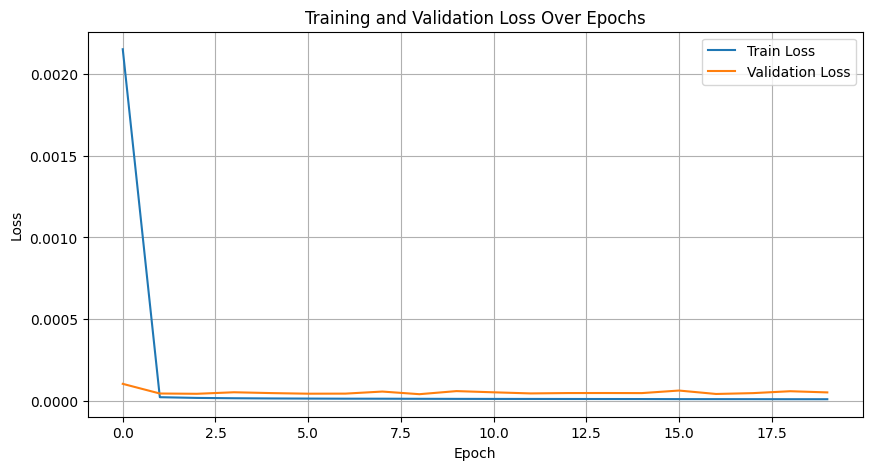

In [26]:
# Train and validate the model
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device, flag=True)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_lstm_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

In [27]:
model_path = "soc_lstm_model.pth"
    
def load_lstm_model(model_path, input_size, hidden_size, num_layers):
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_lstm_model(model_path, input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers)

In [28]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [29]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.000012
Test MAE: 0.002431
Test StdDev: 0.003205


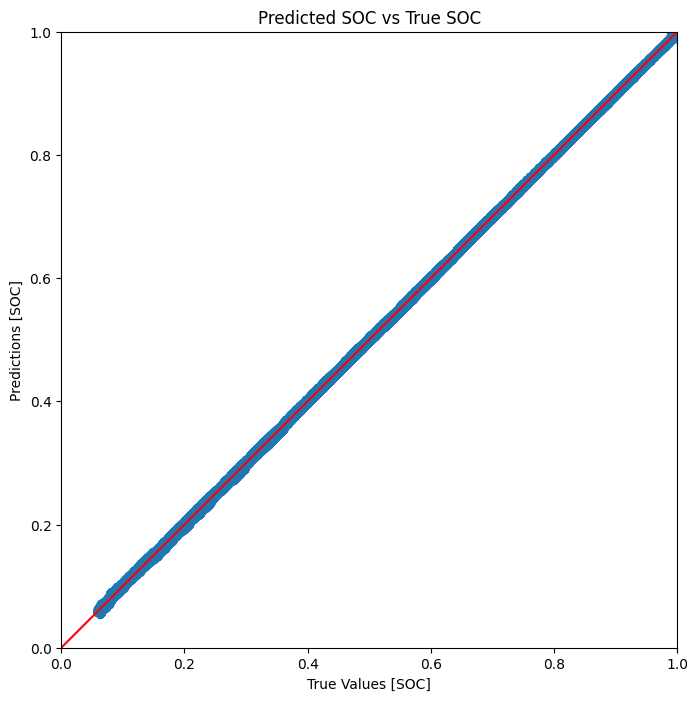

In [30]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

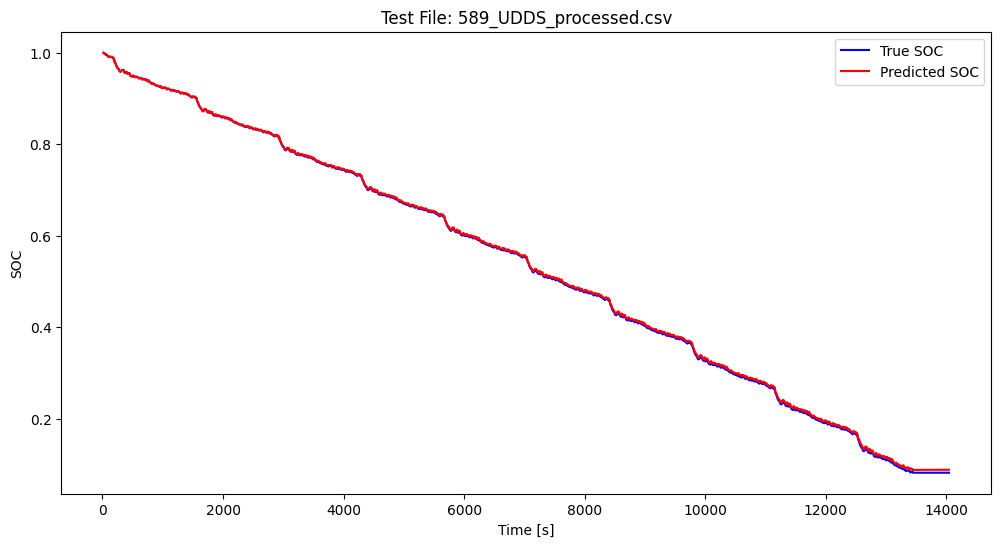

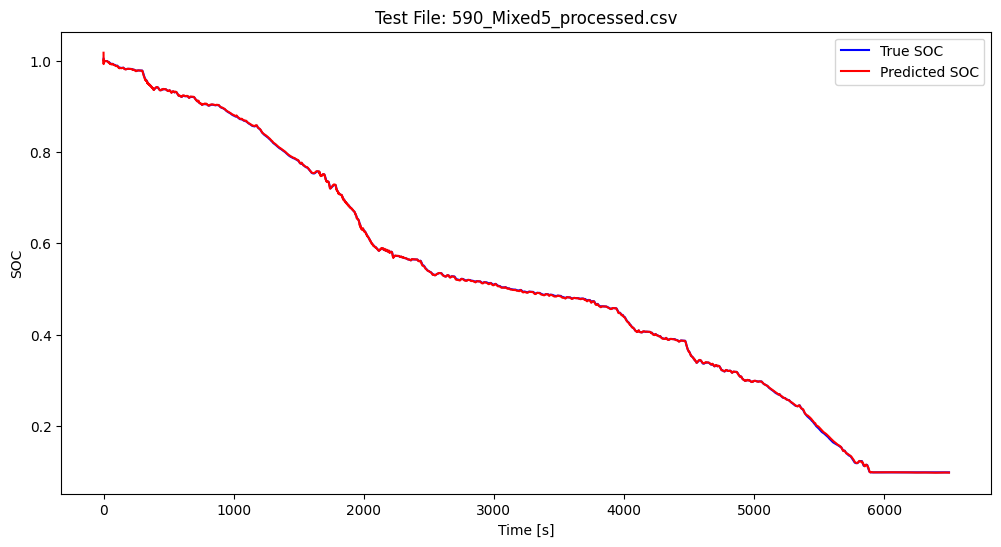

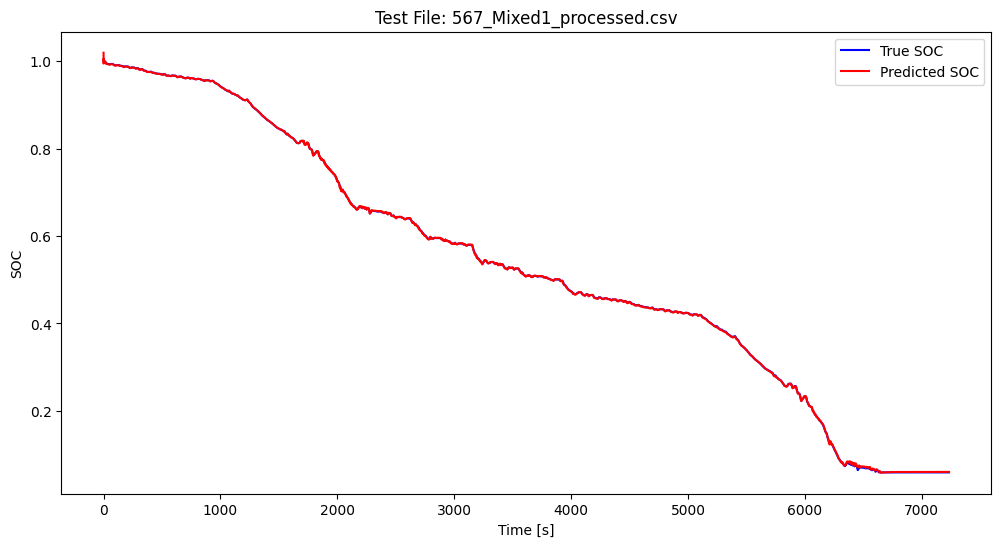

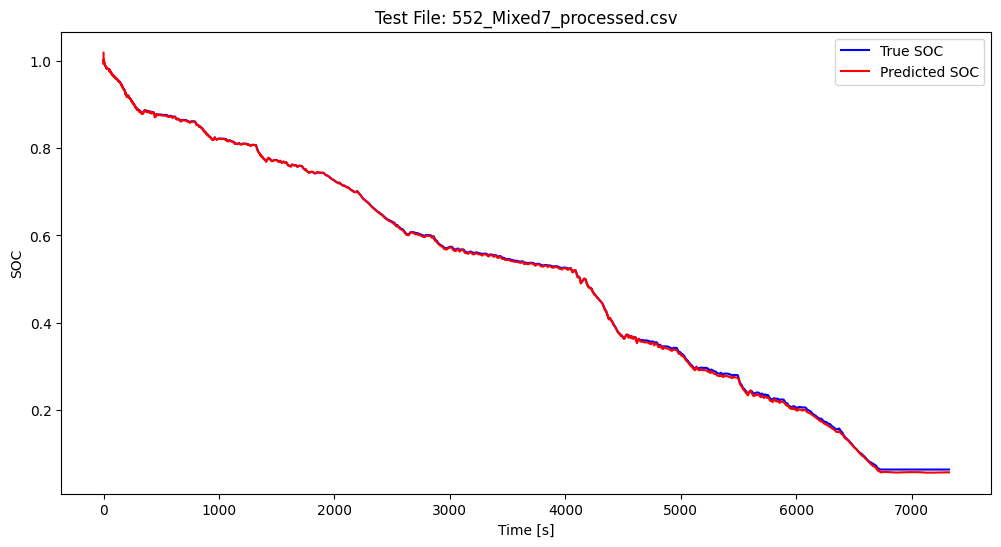

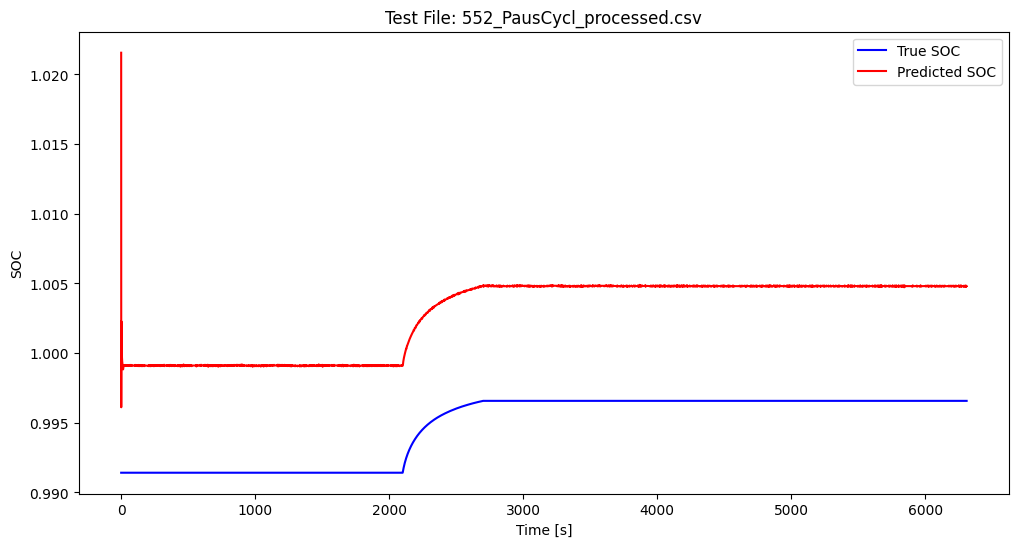

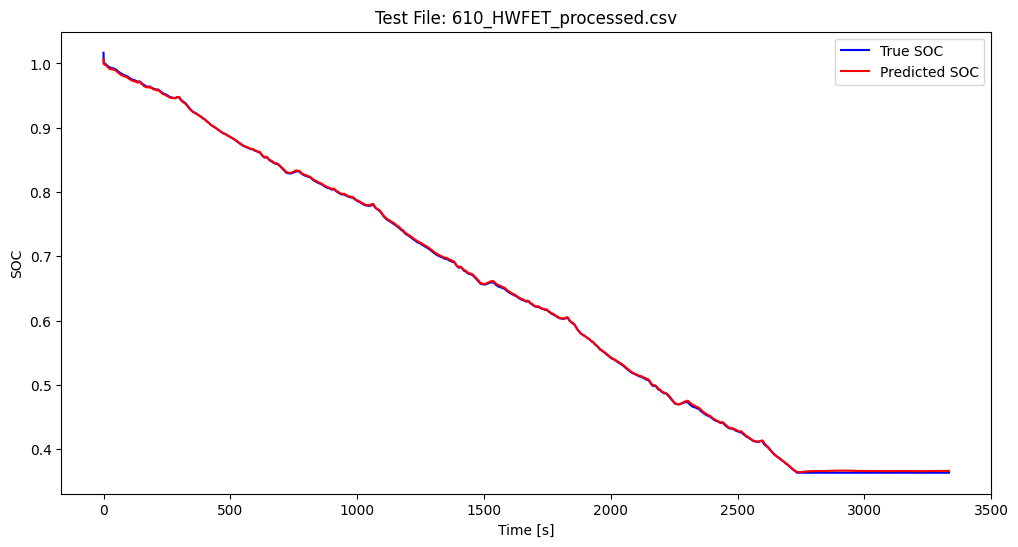

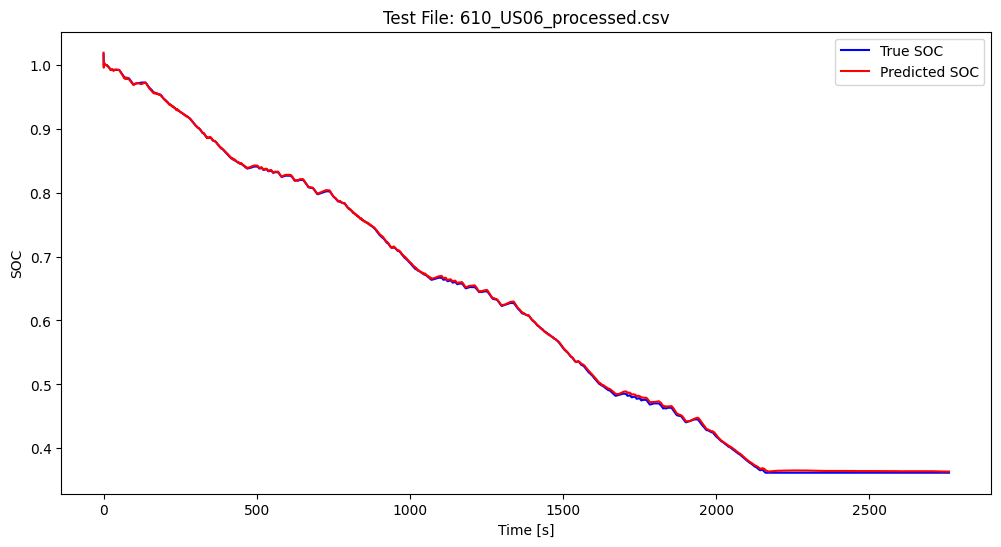

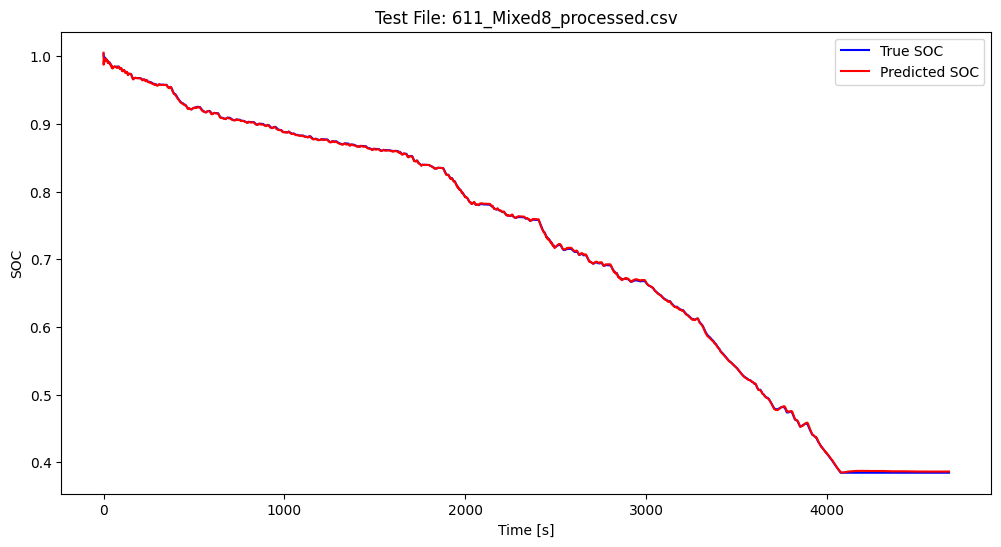

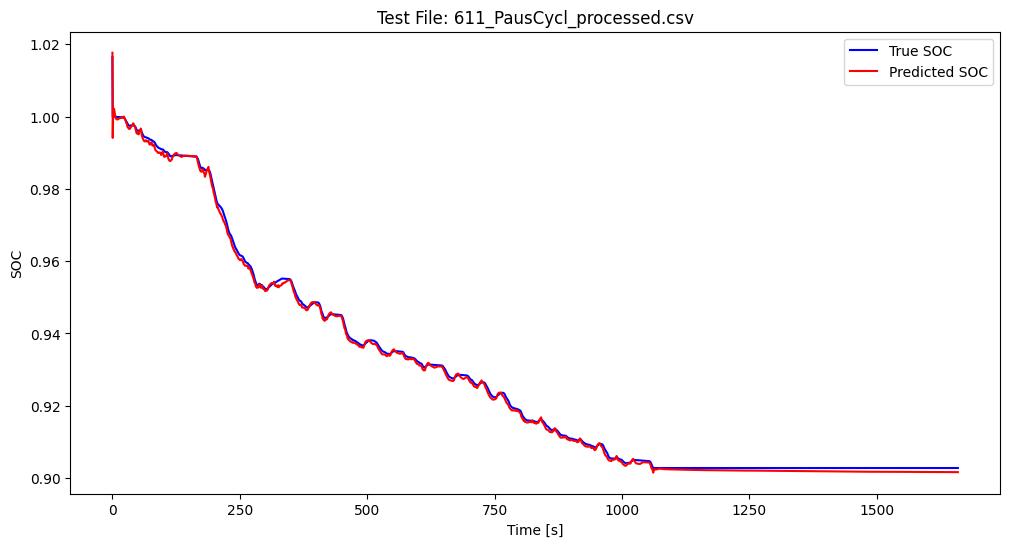

In [31]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)